## Web APIs for data 

files needed = (None! It's all coming from the cloud.)

We have been loading data from files using `pd.read_csv()` and `pd.read_excel()`. Another way to input data into pandas is by directly downloading data from a web server through an *application programming interface* or api. 

The [wikipedia page](https://en.wikipedia.org/wiki/Web_API) isn't that insightful, but an api is a way to directly query a webserver and (in our case) ask for data. An api provides several advantages

1. You only download the data you need
2. You do not need to distribute data files with your code
3. You have access to the 'freshest data'

There are downsides, to using apis, too.

1. You need to be online to retrieve the data
2. The group hosting the data may 'revise' the data, making it difficult to replicate you results
3. The api may change, breaking your code.

On the whole, I find apis very convenient and useful. Let's dig in. We will cover

* Using pandas datareader
* Building our own queries and using the requests package

### The packages
The package `pandas_datareader` collects functions that interact with several popular data sources to access their apis. These include

* ~~Google finance~~
* Morningstar
* St. Louis Fed's Fred (one of my favorites)
* The World Bank
* Eurostat
* Quandl


### API keys

Many data providers do not want some anonymous account connecting to the api and downloading data. These providers ask you to create an account and you are given an *api key* that you pass along with your request. Sometimes keys are free, sometimes they are not.

In this notebook, we will go through a few examples that do not require api keys. At the end of the notebook are a few examples that need api keys. If you sign up for (free) keys, you can try the examples out. We will not go through them in class, because your api key should only be used by you. 

### A quick detour: Installing packages with pip
We use the Anaconda distribution, which bundles python with many [other useful packages](https://docs.anaconda.com/anaconda/packages/pkg-docs/). `pandas_datareader`, however, is not one that is installed by default. \[Remember, we need to *install* a package before we can *import* it. We only need to install the package once. We need to import a package every time we want to use it.\]

We will install the package using 'pip' the python package manager. Before we install a package, let's see what packages we already have installed. 


1. Open an *Anaconda prompt*  (open the start menu and type: 'ana')
2. Run the command `pip list`

Do you see pandas-datareader in the list? If not, it is not installed and not ready to be imported.

In [1]:
import pandas_datareader

 ### Installing a package
 
 1. At the *Anaconda prompt*: run the command `pip install --user pandas_datareader` and hit enter
 2. In your jupyter notebook, **restart the kernel** from the Kernel menu

That should do it. It might take a minute, and fill the command window with text, but in the end it should have installed. You will probably see a message about updating pip. We can safely ignore it. We can confirm that the package is installed by running `pip list` at the *Anaconda prompt* again. \[The option `--user` is important. It tells pip to install the package into our user drive, in which we have permission to save files.\]

Now that the package is installed, we can import it into our program like usual.


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt           # for plotting
import datetime as dt                     # for time and date



# We are importing the data method from the package and calling it web. 
import pandas_datareader.data as web    

myfigsize=(15,8)

## Data through pandas datareader

### FRED
The FRED database is hosted by the St. Louis FRB. It houses lots of economic and financial data. It is US-centric but has some international data, too. 

To use the FRED api you need to know the variable codes. The easiest way to do it to search on the [FRED website](https://fred.stlouisfed.org/).  

The pandas_datareader documentation for FRED is [here](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#fred).

In [2]:
# These codes are for real US gdp and the working-age population.
# The first code seems intuitive; the second does not.
codes = ['GDPCA', 'LFWA64TTUSA647N']  
                                      

# If you do not spec an end date it returns up to the most recent date.
# You can also pass datetime objects as start and end. 
fred = web.DataReader(codes, 'fred', start='1960-01-01')

fred


GDPCA  LFWA64TTUSA647N
DATE                                  
1960-01-01   3262.061     1.019082e+08
1961-01-01   3345.690     1.030842e+08
1962-01-01   3550.684     1.035988e+08
1963-01-01   3705.318     1.054704e+08
1964-01-01   3918.791     1.073338e+08
...               ...              ...
2017-01-01  18076.651     2.055375e+08
2018-01-01  18609.078     2.065078e+08
2019-01-01  19036.052     2.062699e+08
2020-01-01  18509.143     2.057211e+08
2021-01-01  19609.812     2.052548e+08

[62 rows x 2 columns]

Fred already assigned the date variable to the index. You can check to see that it is a datetime index. Nice.

In [3]:
# Give the variables some reasonable names
fred = fred.rename(columns={'GDPCA':'gdp', 'LFWA64TTUSA647N':'wap'})           

# Let's plot real gdp per working age person. The data are in billions, so we multiply out GDP.
fred['gdp_wap'] = fred['gdp']*1000000000/fred['wap']

fred.head(2)

gdp          wap       gdp_wap
DATE                                           
1960-01-01  3262.061  101908250.0  32009.783310
1961-01-01  3345.690  103084250.0  32455.879535

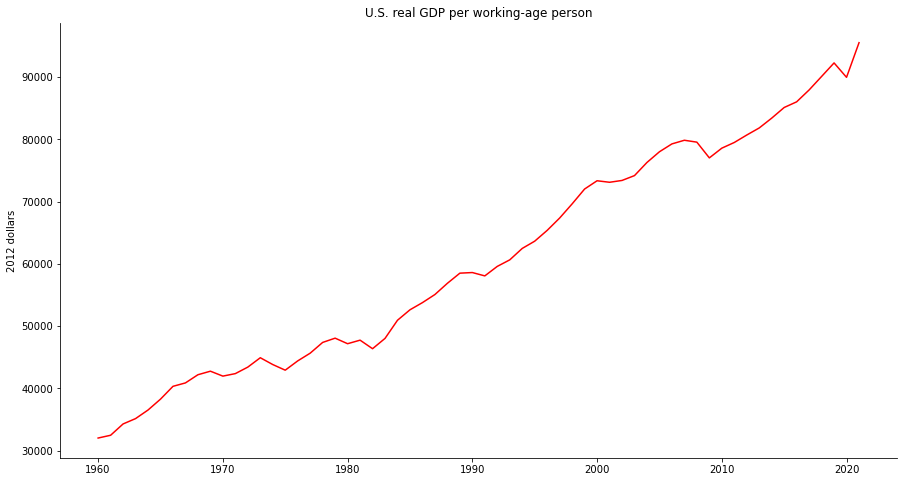

In [4]:
fig, ax = plt.subplots(figsize=myfigsize)

ax.plot(fred.index, fred['gdp_wap'], color='red')

ax.set_ylabel('2012 dollars')
ax.set_title('U.S. real GDP per working-age person')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

### Adding the last observation notation

When I am working with an api, I sometimes like to keep track of the latest observation, since it can change when I rerun the code in the future. Let's get the last date from our DataFrame.

In [5]:
# First, peel off the last observation's index. Note that this is a DatetimeIndex object.
fred.tail(1).index

DatetimeIndex(['2021-01-01'], dtype='datetime64[ns]', name='DATE', freq=None)

In [6]:
# Second, the date attribute of the index gives us an array with the datetime in it. 
fred.tail(1).index.date

array([datetime.date(2021, 1, 1)], dtype=object)

In [7]:
# Third, there is only one observation, so access it using [0].
fred.tail(1).index.date[0]

datetime.date(2021, 1, 1)

In [8]:
# All at once.
fred.tail(1).index.date[0]

datetime.date(2021, 1, 1)

Now I have a datetime object. We know what to do with those. Now my figure will automatically update the text with the correct date.

The data is annual, so the year is enough.

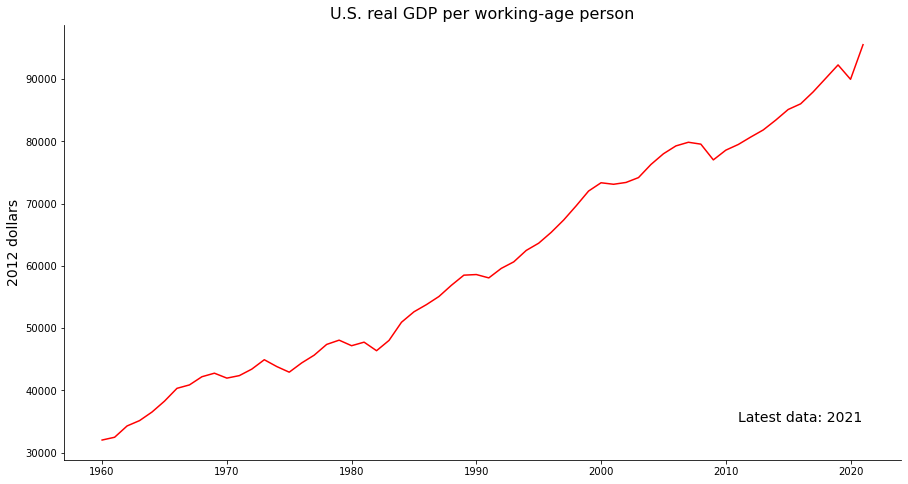

In [9]:
fig, ax = plt.subplots(figsize=myfigsize)

ax.plot(fred.index, fred['gdp_wap'], color='red')

ax.set_ylabel('2012 dollars', fontsize=14)
ax.set_title('U.S. real GDP per working-age person', fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(dt.datetime(2011,1,1), 35000, 'Latest data: {}'.format(fred.tail(1).index.date[0].strftime('%Y')), fontsize=14)

plt.show()

### Stooq for indexes

Stooq provides historical pricing for indexes ([docs](https://pandas-datareader.readthedocs.io/en/latest/readers/stooq.html)). Let's grab the data for the Dow Jones Industrial Index. The ticker symbol for the Dow is '^DJI'. 

In [10]:
# If I do not pass a start or end, it gives the last 5 years. 

dj = web.DataReader('^DJI', 'stooq') # The Dow
sp = web.DataReader('^SPX', 'stooq') # The S&P 500

In [11]:
print(sp.head(2))
print(sp.tail(2))

               Open     High      Low    Close        Volume
Date                                                        
2022-10-25  3799.44  3862.85  3799.44  3859.11  2.707889e+09
2022-10-24  3762.01  3810.74  3741.65  3797.34  2.587424e+09
               Open     High      Low    Close        Volume
Date                                                        
2017-10-30  2577.75  2580.03  2568.25  2572.83  2.032706e+09
2017-10-27  2570.26  2582.98  2565.94  2581.07  2.159506e+09


In [12]:
print(dj.head(2))
print(dj.tail(2))


                Open      High       Low     Close       Volume
Date                                                           
2022-10-25  31463.65  31876.15  31423.53  31836.74  343752750.0
2022-10-24  31187.32  31603.63  31161.41  31499.62  345945262.0
                Open      High       Low     Close       Volume
Date                                                           
2017-10-30  23405.75  23428.75  23327.87  23348.74  436836652.0
2017-10-27  23419.16  23449.40  23353.16  23434.19  518776976.0


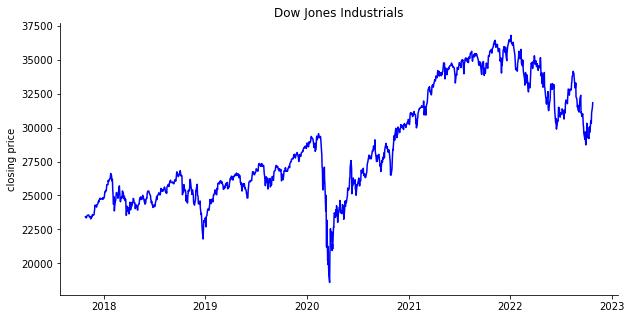

In [13]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(dj.index, dj['Close'], color='blue')

ax.set_ylabel('closing price')
ax.set_title('Dow Jones Industrials')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## Practice: APIs

Take a few minutes and try the following. Feel free to chat with those around if you get stuck. The TA and I are here, too.

How has inflation in the United States evolved over the last 60 years? Let's investigate.

1. Go the FRED website and find the code for the 'Consumer price index for all urban consumers: All items less food and energy' 
2. Use the api to get the data from 1960 to the most recent. What frequency is the data?

In [14]:
# This is monthly data.
start = dt.datetime(1960, 1, 1)
cpi = web.DataReader('CPILFESL', 'fred', start)
cpi.tail(2)

CPILFESL
DATE                
2022-08-01    296.95
2022-09-01    298.66

3. Create a variable in your DataFrame that holds the growth rate of the CPI&mdash;the inflation rate. Compute it in percentage terms. 

   Remember `.pct_change()`?

In [15]:
cpi['inflation'] = cpi['CPILFESL'].pct_change()*100
cpi.head()

CPILFESL  inflation
DATE                           
1960-01-01      30.5        NaN
1960-02-01      30.6   0.327869
1960-03-01      30.6   0.000000
1960-04-01      30.6   0.000000
1960-05-01      30.6   0.000000

4. Plot it. What patterns do you see? 

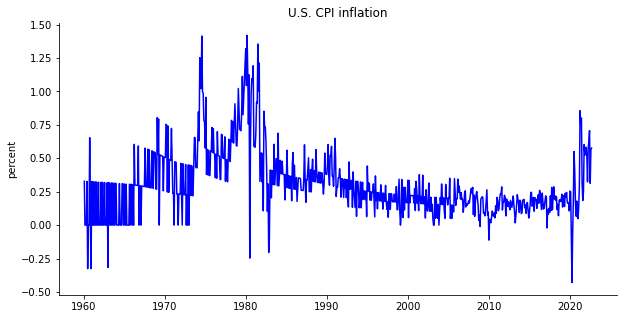

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(cpi.index, cpi['inflation'], color='blue')

ax.set_ylabel('percent')
ax.set_title('U.S. CPI inflation')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

5. Challenging. We computed the month-to-month inflation rate above. This is not the inflation rate we usually report. Can you compute and plot the year-over-year inflation rate? For example, the inflation rate for 1962-05-01 would be the cpi in 1962-05-01 divided by the cpi in 1961-05-01. 

\[Hint: Check the documentation for `pct_change()`.\]

In [17]:
cpi['infl_year'] = cpi['CPILFESL'].pct_change(periods=12)*100

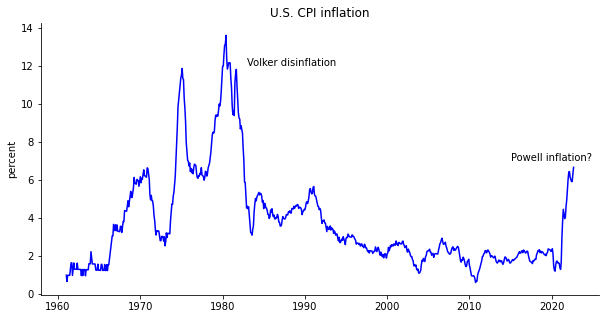

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(cpi.index, cpi['infl_year'], color='blue')

ax.set_ylabel('percent')
ax.set_title('U.S. CPI inflation')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(dt.datetime(1983, 1,1), 12, 'Volker disinflation')
ax.text(dt.datetime(2015, 1,1), 7, 'Powell inflation?')

plt.show()

6. Annotate the decrease in inflaton around 1983 as 'Volker disinflation'

## Data without datareader

Some data providers have apis that do not have packages written for them. These apis take a bit more work, including figuring out how to provide the search terms. 

Let's look at the Census Bureau's trade data api. The Census (and many of the national statistical agencies) has an api that takes a bit of work to set up. 

The documentation: https://www.census.gov/foreign-trade/reference/guides/Guide%20to%20International%20Trade%20Datasets.pdf

We are going to retrieve data on the value of U.S. imports of goods, classified by the Harmonized Sytem, from Canada. 

We start with an *endpoint*. Think of it as the address of the server that we want to ask for data (query). Then we build up a string with the requests of the data we need.

In [19]:
# This is the harmonized system endpoint. I learned this from reading the documentation.

base_url = 'https://api.census.gov/data/timeseries/intltrade/imports/hs?'

For this particular api (they are all different...read the docs) we need to specify which variables we want, at what level of disagregation we want the data reported, which countries we want imports from, and from what time period. 

In [20]:
variables = 'GEN_VAL_MO,I_COMMODITY'  # general merchandise value, classification number
level = 'HS10'                        # 10-digit harmonized system classification
country = '1220'                      # Canada
dates = '2020-01'                     # 2021-01

Now we build the url that asks for the data. This is a string. 

* We use `=` to specify the parameters
* We use `&` to add together the different conditional statements

In [21]:
query = base_url + 'get=' + variables + '&COMM_LVL=' + level + '&CTY_CODE=' + country + '&time=' + dates
query

'https://api.census.gov/data/timeseries/intltrade/imports/hs?get=GEN_VAL_MO,I_COMMODITY&COMM_LVL=HS10&CTY_CODE=1220&time=2020-01'

Copy url (without the quotes) and put it into a web browser. What do you get?

We use the requests package to get the url contents through python ([docs](https://requests.readthedocs.io/en/latest/)). 

In [22]:
import requests
response = requests.get(query)
type(response)

requests.models.Response

The `Response` object has an attribute `.status_code` which we can check. Status codes are list [here](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes).

In [23]:
response.status_code


200

Success. 

Okay, now we have the data...how do we get it into a DataFrame? `Response.content` looks promising...

In [24]:
response.content

b'[["GEN_VAL_MO","I_COMMODITY","COMM_LVL","CTY_CODE","time"],\n["3861852","3907400000","HS10","1220","2020-01"],\n["52644","3907500000","HS10","1220","2020-01"],\n["2901080","3907610010","HS10","1220","2020-01"],\n["3091800","3907610050","HS10","1220","2020-01"],\n["94326","3907690010","HS10","1220","2020-01"],\n["626110","3907690050","HS10","1220","2020-01"],\n["1096","3907700000","HS10","1220","2020-01"],\n["168357","3907914000","HS10","1220","2020-01"],\n["5917915","3907915000","HS10","1220","2020-01"],\n["9502","3907992000","HS10","1220","2020-01"],\n["319447","3907995010","HS10","1220","2020-01"],\n["5283948","3907995050","HS10","1220","2020-01"],\n["9046273","3908100000","HS10","1220","2020-01"],\n["1113","3908902000","HS10","1220","2020-01"],\n["80654","3908907000","HS10","1220","2020-01"],\n["565609","3909100000","HS10","1220","2020-01"],\n["320503","3909200000","HS10","1220","2020-01"],\n["680","3909310000","HS10","1220","2020-01"],\n["239930","3909390000","HS10","1220","2020-

That gave use the data formatted for text&mdash;what we saw in the browser. Let's try again.

JSON stands for [JavaScript Object Notation](https://en.wikipedia.org/wiki/JSON) and is a format that is commonly used to store data transmitted on the internet. The `.json()` method of the response object tries to convert the content of the webpage into a standard format. 

In [25]:
data = response.json()
data

[['GEN_VAL_MO', 'I_COMMODITY', 'COMM_LVL', 'CTY_CODE', 'time'],
 ['3861852', '3907400000', 'HS10', '1220', '2020-01'],
 ['52644', '3907500000', 'HS10', '1220', '2020-01'],
 ['2901080', '3907610010', 'HS10', '1220', '2020-01'],
 ['3091800', '3907610050', 'HS10', '1220', '2020-01'],
 ['94326', '3907690010', 'HS10', '1220', '2020-01'],
 ['626110', '3907690050', 'HS10', '1220', '2020-01'],
 ['1096', '3907700000', 'HS10', '1220', '2020-01'],
 ['168357', '3907914000', 'HS10', '1220', '2020-01'],
 ['5917915', '3907915000', 'HS10', '1220', '2020-01'],
 ['9502', '3907992000', 'HS10', '1220', '2020-01'],
 ['319447', '3907995010', 'HS10', '1220', '2020-01'],
 ['5283948', '3907995050', 'HS10', '1220', '2020-01'],
 ['9046273', '3908100000', 'HS10', '1220', '2020-01'],
 ['1113', '3908902000', 'HS10', '1220', '2020-01'],
 ['80654', '3908907000', 'HS10', '1220', '2020-01'],
 ['565609', '3909100000', 'HS10', '1220', '2020-01'],
 ['320503', '3909200000', 'HS10', '1220', '2020-01'],
 ['680', '3909310000'

This looks like a nested list. The first sub-list is the column headers. Each following sub-list is a row of data. 

In [26]:
data[0]

['GEN_VAL_MO', 'I_COMMODITY', 'COMM_LVL', 'CTY_CODE', 'time']

In [27]:
data[1]

['3861852', '3907400000', 'HS10', '1220', '2020-01']

In [28]:
imports = pd.DataFrame(data[1:], columns=data[0])
imports.head()

GEN_VAL_MO I_COMMODITY COMM_LVL CTY_CODE     time
0    3861852  3907400000     HS10     1220  2020-01
1      52644  3907500000     HS10     1220  2020-01
2    2901080  3907610010     HS10     1220  2020-01
3    3091800  3907610050     HS10     1220  2020-01
4      94326  3907690010     HS10     1220  2020-01

That took more work than pandas datareader, but wasn't terrible. Now that we know how to use this api, we can easily download exactly what we need in a programatic way. 

## Practice: APIs on hard mode

Let's try some more downloads from Census. 

1. Try this string in a browser:

```python
'https://api.census.gov/data/timeseries/intltrade/imports/hs?get=GEN_VAL_MO,CTY_NAME&CTY_CODE=2010&time=from+2015-01'
```
   What kind of data is this? What is the unit of observation?


In [29]:
# 1. This is a time series of imports from Mexico at a monthly frequency. 

2. Use `requests.get()` to retrieve the contents of the webpage at the url. 
3. Check the status code, was this successful? 

In [30]:
query = 'https://api.census.gov/data/timeseries/intltrade/imports/hs?get=GEN_VAL_MO,CTY_NAME&CTY_CODE=2010&time=from+2015-01'
response = requests.get(query)
response.status_code

200

4. Use the `.json()` method of the response to turn the data into nested lists. 
5. Turn the nested lists into a DataFrame.
6. Check the dtypes. Make the dates datetime and the GEN_VAL_MO float.  

In [31]:
mexico_json = response.json()
mexico = pd.DataFrame(mexico_json[1:], columns=mexico_json[0])

mexico['time'] = pd.to_datetime(mexico['time'])
mexico.set_index('time', inplace=True)
mexico['GEN_VAL_MO'] = mexico['GEN_VAL_MO'].astype(float)
mexico.head()

GEN_VAL_MO CTY_NAME CTY_CODE
time                                      
2015-01-01  2.226109e+10   MEXICO     2010
2015-02-01  2.270655e+10   MEXICO     2010
2015-03-01  2.565168e+10   MEXICO     2010
2015-04-01  2.470475e+10   MEXICO     2010
2015-05-01  2.448250e+10   MEXICO     2010

7. Plot imports from Mexico with time on the x-axis.  Does anything stand out?

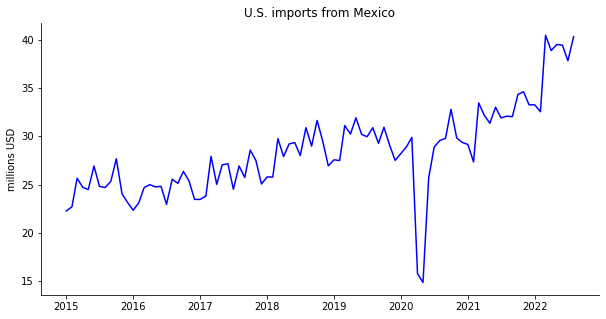

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(mexico.index, mexico['GEN_VAL_MO']/1000000000, color='blue')

ax.set_ylabel('millions USD')
ax.set_title('U.S. imports from Mexico')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

8. Retrieve the content at this url using `requests.get()`. What is the status code?

```python
'https://api.census.gov/data/timeseries/intltrade/imports/hs?get=GEN_VAL_MO,CTY_NAME&CTY_CODE=5070'
```



In [33]:
url = 'https://api.census.gov/data/timeseries/intltrade/imports/hs?get=GEN_VAL_MO,CTY_NAME&CTY_CODE=5070'
response = requests.get(url)
response.status_code

400

9. What does the status code mean? Paste the link into the browser. 
10. Then, try the `.content` attribute of your response object. 

In [34]:
response.content

b'error: error: missing required variable/predicate: time'

# The examples below requires an api key

Where you see the code `your_key` is where you should enter your own api key. You need to go to their websites and sign up. The examples should work then. 

### Stock prices with iex

According to the [docs](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#morningstar):
>The Investors Exchange (IEX) provides a wide range of data through an API. Historical stock prices are available for up to 5 years.

IEX is one of those companies that requires an api key. These keys can be [pricey](https://iexcloud.io/pricing/) because their target market are business and app developers. They offer a free key, though for experimentation. Very cool of them. 

You can sign up here: [https://iexcloud.io/cloud-login#/register/](https://iexcloud.io/cloud-login#/register/)

In [36]:
# Sometimes you pass your key in the DataReader method. In this case, you save your key as an environmental variable. 
# This means you do not need to keep specifying your key each time you use IEX.

import os
os.environ["IEX_API_KEY"] = 'your_key'

In [37]:
# Harley Davidson prices. The ticker is 'HOG'

start = dt.datetime(2016, 9, 1)
end = dt.datetime(2022, 3, 21)

harley = web.DataReader('HOG', 'iex', start, end)

In [38]:
harley.tail()


open   high      low  close   volume
date                                             
2022-03-15  37.96  38.57  37.6401  38.04  1147738
2022-03-16  38.73  40.32  38.3800  39.44  2000807
2022-03-17  38.96  39.73  38.7200  39.10  1792586
2022-03-18  39.08  40.73  38.5900  40.35  2463025
2022-03-21  40.56  40.87  39.1700  39.44  2781190

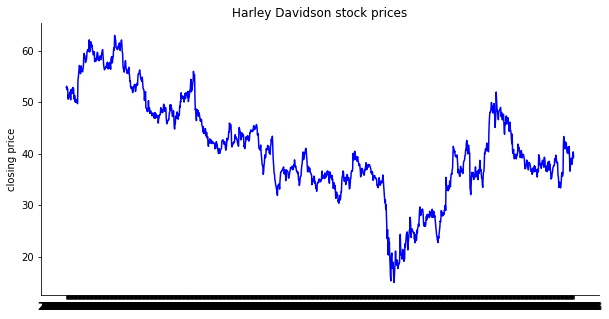

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(harley.index, harley['close'], color='blue')

ax.set_ylabel('closing price')
ax.set_title('Harley Davidson stock prices')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [40]:
# Ahhh! Not a good looking figure.

# We need to set the index to a datetime object so mpl can get the axis right...
# FRED did this for us. 

harley.index = pd.to_datetime(harley.index)

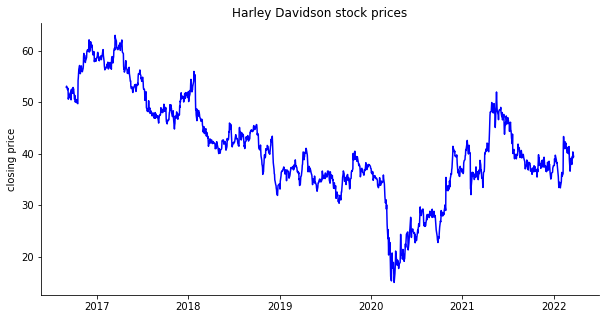

In [41]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(harley.index, harley['close'], color='blue')

ax.set_ylabel('closing price')
ax.set_title('Harley Davidson stock prices')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## Quandl (now named Nasdaq Data Link)

[Quandl](https://www.quandl.com/) is another data aggregation site. Like FRED or IEX, it collects data from several sources and makes them available. 

>The premier source for financial, economic, and alternative datasets, serving investment professionals. Quandl’s platform is used by over 400,000 people, including analysts from the world’s top hedge funds, asset managers and investment banks.


Quandl has free and pay-to-use data. You can sign up for a free api key. Quandl has also developed their own [python package](https://www.quandl.com/tools/python).

The U.S. Department of Energy data is available through this facility (and is free). The quandl code for [natural gas futures](https://www.quandl.com/data/EIA/NG_RNGC3_M-Natural-Gas-Futures-Contract-3-Monthly)  is `EIA/NG_RNGC3_M`. Let's take a look.

In [42]:
# You will need to provide your quandl key.
my_quandl_key = 'your_key'

gas = web.DataReader('EIA/NG_RNGC3_M', 'quandl', api_key=my_quandl_key)
print(gas.head(2))
print(gas.tail(2))

            Value
Date             
2022-01-31   3.91
2021-12-31   3.67
            Value
Date             
2017-11-30  3.149
2017-10-31  3.203


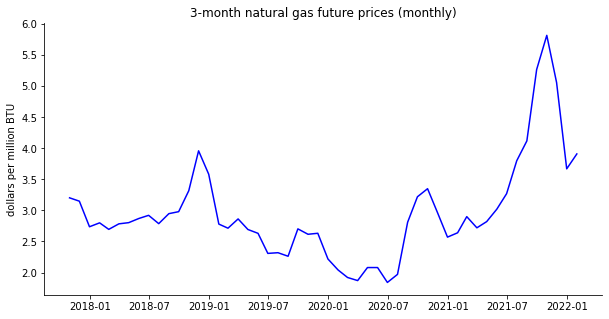

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(gas.index, gas['Value'], color='blue')

ax.set_ylabel('dollars per million BTU')
ax.set_title('3-month natural gas future prices (monthly)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()